In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from statsmodels.graphics.tsaplots import plot_pacf

from darkgreybox.models import TiTe
from darkgreybox.fit import train_models
from docs.tutorials.util.plot import plot

/Users/csaba/.pyenv/versions/3.8.7/envs/darkgreybox/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


2022-01-28 15:17:38,717 darkgreybox  INFO     Logging enabled...


## Demo Notebook 03 - TiTe Model Wrapper Fit PASS

This notebook demonstrates the usage of the `DarkGreyBox` models via fitting them with a wrapper function for a `TiTe` model. 


Our temporal resolution is 1 hour

In [2]:
# the duration of a record
rec_duration = 1 # hour

Read some demo data.  
* Ph: Heating system power output
* Ta: Ambient temperature
* Ti: Internal temperature

We are also setting a set of custom fields in our input data: `Ti0` and `Te0`. These fields define the initial conditions for `Ti` and `Te` for each record of the input data respectively. E.g. if a sub-model is trained based on the 10-20 records of the training data, the initial conditions for the above params will be set by the 10. record of the input data. 

Note: This demo data is intentionally far from ideal and particularly challenging to model with low errors. It is taken from a building where there are many factors influencing the heat dynamics of the building that are not accounted for in the modelling (solar gains, passive gains, hot water demand, gas use in the canteen etc.). The time period is relatively short to maintain a reasonable solution time for the demo. However, it includes an also challenging holiday period when the heating system is shut down.

In [4]:
input_df = pd.read_csv('./data/demo_data.csv', index_col=0, parse_dates=True)

input_df['Ti0'] = input_df['Ti']
input_df['Te0'] = input_df['Ti'] - 2

input_X = input_df[['Ph', 'Ta', 'Ti0', 'Te0']]
input_y = input_df['Ti']

print(f'Input X shape: {input_X.shape}, input y shape: {input_y.shape}')

Input X shape: (792, 4), input y shape: (792,)


Use the `sklearn.model_selection.train_test_split` function to split the input data into train and test data. (Input data is 33 days long and 5 days of test data is specified)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(input_X, input_y, test_size=5 / 33, shuffle=False)

print(f'Train: X shape: {X_train.shape}, y shape: {y_train.shape}')
print(f'Test: X shape: {X_test.shape}, y shape: {y_test.shape}')

Train: X shape: (672, 4), y shape: (672,)
Test: X shape: (120, 4), y shape: (120,)


Set up the model training parameters.  

The `Ti0` param is the initial condition for the internal temperature at t=0 - this is set to the first record of `X_train['Ti0']` as described above and is fixed, hence `vary: False`.  

The `Te0` param is the initial condition for the building envelope temperature at t=0 - - this is set to the first record of `X_train['Te0']` as described above and is NOT fixed, hence `vary: True`.  

`Ci`, `Ce`, `Rie` and `Ria` params are the initial conditions for these thermal parameters. As these will be fit by the model training their default is `vary: True`. The values for these params' initial conditions are set arbitrarily to `1` it is assumed that no estimates have been calculated for them (e.g. based on building physical properties).


In [6]:
train_params = {
    'Ti0': {'value': X_train.iloc[0]['Ti0'], 'vary': False},
    'Te0': {'value': X_train.iloc[0]['Te0'], 'vary': True, 'min': 10, 'max': 25},
    'Ci': {'value': 1},
    'Ce': {'value': 1},
    'Rie': {'value': 1},
    'Rea': {'value': 1},
}

We call the `train_models` wrapper function, passing it:

* `models`: An `TiTe` model instantiated with the initial `train_params` as set above
* `X_train`: The X of the train set
* `y_train`: The y of the train set
* `splits`: A list of training data indices specifying sub-sections of `X_train` and `y_train` for the models to be trained on. We use `sklearn.model_selection.KFold` to split the train set into chunks with lenghts of a single day each.
* `error_metric`: An error metric function that confirms to the `sklearn.metrics` interface. The model results will be evaluated based on this metric. 
* `method`: Name of the fitting method to use. Valid values are described in: `lmfit.minimize`. We are passing `nelder` here as it is generally quicker than `leastsq`.
* `n_jobs`: The number of parallel jobs to be run as described by `joblib.Parallel`. We are passing `-1` here to use all available CPU cores.
* `verbose`: The degree of verbosity as described by `joblib.Parallel`. We are passing `10` here for medium verbosity.


In [7]:
prefit_df = train_models(models=[TiTe(train_params, rec_duration=1)],
                         X_train=X_train, 
                         y_train=y_train, 
                         splits=KFold(n_splits=int(len(X_train) / 24), shuffle=False).split(X_train), 
                         error_metric=mean_squared_error,
                         method='nelder', 
                         n_jobs=-1, 
                         verbose=10)

2022-01-28 15:18:48,561 darkgreybox  INFO     Training models...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


2022-01-28 15:18:49,306 darkgreybox  INFO     Logging enabled...
2022-01-28 15:18:49,306 darkgreybox  INFO     Logging enabled...
2022-01-28 15:18:49,307 darkgreybox  INFO     Logging enabled...
2022-01-28 15:18:49,308 darkgreybox  INFO     Logging enabled...
2022-01-28 15:18:49,307 darkgreybox  INFO     Logging enabled...
2022-01-28 15:18:49,311 darkgreybox  INFO     Logging enabled...
2022-01-28 15:18:49,311 darkgreybox  INFO     Logging enabled...
2022-01-28 15:18:49,318 darkgreybox  INFO     Logging enabled...


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  16 out of  28 | elapsed:    5.7s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:    5.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  22 out of  28 | elapsed:    6.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:    6.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:    7.3s finished


This returns a dataframe with a record for each split showing:
* `start_date`: the start date of the train sub set for which the model was fit
* `end_date`: the end date of the train sub set for which the model was fit
* `model`: the fit model object
* `model_result`: the model result that was generated by the model's `predict` method for the train sub set
* `time`: the time it took for the fitting process to complete
* `method`: the fitting method
* `error`: the error of the model for the `y` variable (in this case the MSE)

In [8]:
prefit_df

,start_date,end_date,model,model_result,time,method,error
0,2019-12-23 00:00:00+00:00,2019-12-23 23:00:00+00:00,<darkgreybox.models.TiTe object at 0x126b087f0>,"DarkGreyModelResult(Z=array([18.1375 , 17.1...",0.244252,nelder,11.406733
1,2019-12-24 00:00:00+00:00,2019-12-24 23:00:00+00:00,<darkgreybox.models.TiTe object at 0x126ad8820>,"DarkGreyModelResult(Z=array([19.3625 , 19.1...",0.325435,nelder,0.018890
2,2019-12-25 00:00:00+00:00,2019-12-25 23:00:00+00:00,<darkgreybox.models.TiTe object at 0x126ae69a0>,"DarkGreyModelResult(Z=array([19.7875 , 19.6...",2.555123,nelder,0.026962
3,2019-12-26 00:00:00+00:00,2019-12-26 23:00:00+00:00,<darkgreybox.models.TiTe object at 0x126ad8be0>,"DarkGreyModelResult(Z=array([18.3125 , 18.2...",0.477023,nelder,0.001699
4,2019-12-27 00:00:00+00:00,2019-12-27 23:00:00+00:00,<darkgreybox.models.TiTe object at 0x126b088b0>,"DarkGreyModelResult(Z=array([17.1125 , 17.0...",0.640743,nelder,0.001673
5,2019-12-28 00:00:00+00:00,2019-12-28 23:00:00+00:00,<darkgreybox.models.TiTe object at 0x126ae6e20>,"DarkGreyModelResult(Z=array([16.2875 , 16.2...",2.541821,nelder,0.000211
6,2019-12-29 00:00:00+00:00,2019-12-29 23:00:00+00:00,<darkgreybox.models.TiTe object at 0x126affdc0>,"DarkGreyModelResult(Z=array([15.6 , 15.5...",2.529565,nelder,0.010708
7,2019-12-30 00:00:00+00:00,2019-12-30 23:00:00+00:00,<darkgreybox.models.TiTe object at 0x126ae69d0>,"DarkGreyModelResult(Z=array([15.0875 , 12.9...",2.607300,nelder,37.927944
8,2019-12-31 00:00:00+00:00,2019-12-31 23:00:00+00:00,<darkgreybox.models.TiTe object at 0x126ae62e0>,"DarkGreyModelResult(Z=array([15.3125 , 15.2...",0.208122,nelder,0.000318
9,2020-01-01 00:00:00+00:00,2020-01-01 23:00:00+00:00,<darkgreybox.models.TiTe object at 0x126ae8670>,"DarkGreyModelResult(Z=array([14.625 , 10.4...",2.550822,nelder,8.973590


In this case, each record is a model fit for a single day. The params of these pre-fit models can be used to train models for the entire duration of the train set. 

We call the `train_models` wrapper function again, passing it (showing only different arguments:

* `models`: a list of the pre-fit models 
* `splits`: None - as we want to fit for the entire train set


In [9]:
train_df = train_models(models=prefit_df['model'],
                        X_train=X_train, 
                        y_train=y_train, 
                        splits=None, 
                        error_metric=mean_squared_error,
                        method='nelder', 
                        n_jobs=-1, 
                        verbose=10)

2022-01-28 15:19:03,590 darkgreybox  INFO     Training models...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1312s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  16 out of  28 | elapsed:   13.0s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done  19 out of  28 | elapsed:   47.6s remaining:   22.6s
[Parallel(n_jobs=-1)]: Done  22 out of  28 | elapsed:   48.1s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  25 out of  28 | elapsed:   49.4s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   56.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed:   56.9s finished


This returns a dataframe with a record for each pre-fit model containing the model objects and model results.

In [10]:
train_df

,start_date,end_date,model,model_result,time,method,error
0,2019-12-23 00:00:00+00:00,2020-01-19 23:00:00+00:00,NaN,NaN,0.188294,nelder,NaN
1,2019-12-23 00:00:00+00:00,2020-01-19 23:00:00+00:00,NaN,NaN,0.160120,nelder,NaN
2,2019-12-23 00:00:00+00:00,2020-01-19 23:00:00+00:00,NaN,NaN,0.081934,nelder,NaN
3,2019-12-23 00:00:00+00:00,2020-01-19 23:00:00+00:00,NaN,NaN,0.201751,nelder,NaN
4,2019-12-23 00:00:00+00:00,2020-01-19 23:00:00+00:00,NaN,NaN,0.450531,nelder,NaN
5,2019-12-23 00:00:00+00:00,2020-01-19 23:00:00+00:00,NaN,NaN,0.087772,nelder,NaN
6,2019-12-23 00:00:00+00:00,2020-01-19 23:00:00+00:00,NaN,NaN,0.226075,nelder,NaN
7,2019-12-23 00:00:00+00:00,2020-01-19 23:00:00+00:00,<darkgreybox.models.TiTe object at 0x126be8580>,"DarkGreyModelResult(Z=array([ 1.81375000e+001,...",47.709838,nelder,inf
8,2019-12-23 00:00:00+00:00,2020-01-19 23:00:00+00:00,NaN,NaN,0.090002,nelder,NaN
9,2019-12-23 00:00:00+00:00,2020-01-19 23:00:00+00:00,<darkgreybox.models.TiTe object at 0x126be8640>,"DarkGreyModelResult(Z=array([ 1.81375000e+001,...",47.371007,nelder,inf


We can select the model with the lowest error and display its params

In [11]:
select_idx = train_df['error'].argmin()

model = train_df.loc[select_idx, 'model']
train_results = train_df.loc[select_idx, 'model_result']

model.result.params

name,value,standard error,relative error,initial value,min,max,vary
Ti0,18.1375000,0.00000000,(0.00%),18.1375,-inf,inf,False
Te0,16.8310431,0.11157696,(0.66%),16.1375,10.0000000,25.0000000,True
Ci,184.890748,5.25904113,(2.84%),14.07835533256204,-inf,inf,True
Ce,483.231457,15.3675848,(3.18%),9.423834996894758,-inf,inf,True
Rie,0.11119564,0.00454589,(4.09%),0.19972994685761403,-inf,inf,True
Rea,0.52298050,0.00503848,(0.96%),0.05342883055090569,-inf,inf,True


Plot the modelled and measured data for the train set.  

This yields a much better fit than the `Ti` model in `Demo 01`. (Bear in mind the complexity of the input data e.g. the building overheating during the second week of January.) We can also see the building envelope temperature `Te` on the plots.

/Users/csaba/.pyenv/versions/3.8.7/envs/darkgreybox/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


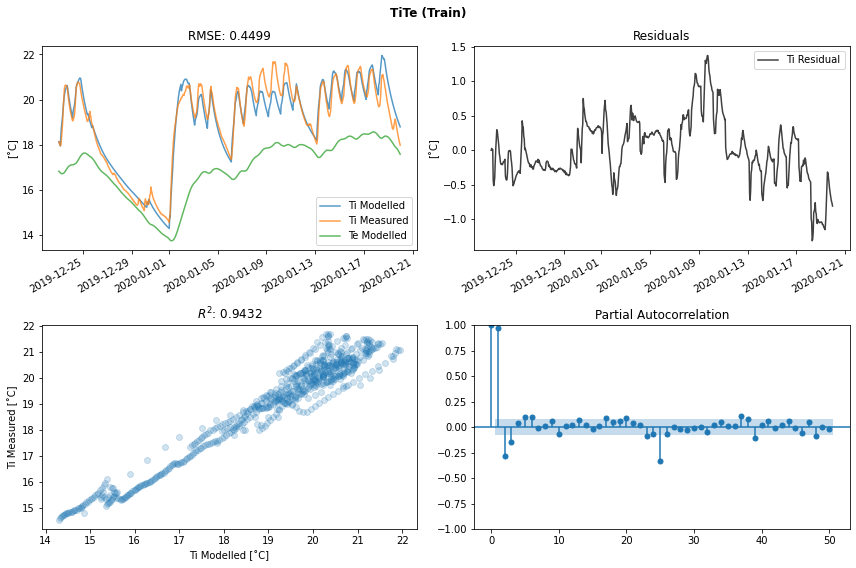

In [12]:
plot(y_train, train_results, 'TiTe (Train)')

To get the test results, the model takes `X_test` as the input data. Also, as the initial conditions for `Ti0` and `Te0` params at t=0 are different at the start of the test data to what the model params currently holds (which is `Ti0` and `Te0` at t=0 of the *training data*), we need to update those variables. For `Ti0` this is the same as before - we set it at the first value of `Ti` in the test set. We do not have a measured value for `Te0` though, so we take the last predicted value of `Te` of the model on the training set.

In [14]:
test_results = model.predict(X=X_test, ic_params={'Ti0': y_test.iloc[0], 'Te0': train_results.var['Te'][-1]})

Plot the modelled and measured data for the test set.  

As expected, the `TiTe` model generalises much better than a `Ti` model on data it has not seen before.

/Users/csaba/.pyenv/versions/3.8.7/envs/darkgreybox/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


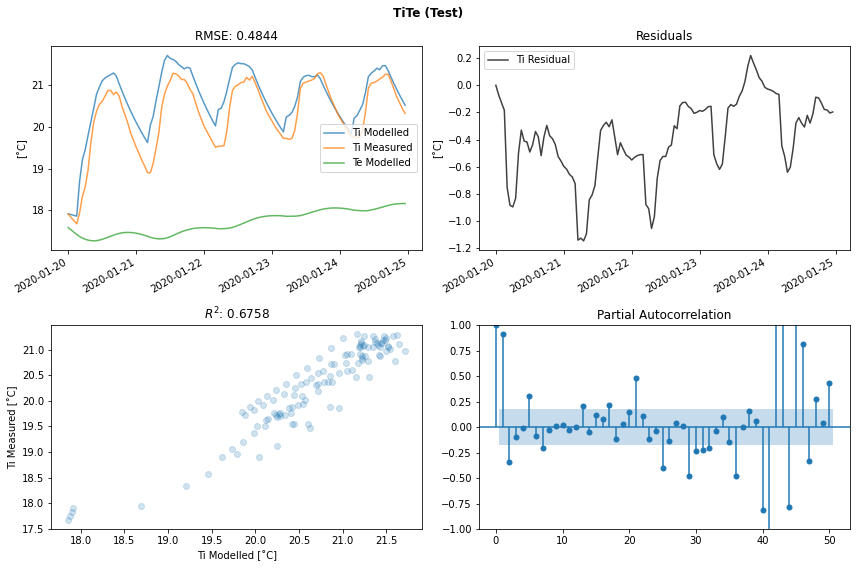

In [15]:
plot(y_test, test_results, 'TiTe (Test)')